In [13]:
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import add_changepoints_to_plot
from neuralprophet import NeuralProphet
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import shap

WARNING - (py.warnings._showwarnmsg) - C:\Users\benke\AppData\Local\Temp\ipykernel_10968\3719743408.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays['lower_window'] = -7

WARNING - (py.warnings._showwarnmsg) - C:\Users\benke\AppData\Local\Temp\ipykernel_10968\3719743408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays['upper_window'] = 7

WARNING - (py.warnings._showwarnmsg) - C:\Users\benke\AppData\Local\Temp\ipykernel_10968\3719743408.py:10: SettingWithCopyWarning: 
A value is tryi

WARNING - (py.warnings._showwarnmsg) - c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\prophet\forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])

20:04:46 - cmdstanpy - INFO - Chain [1] start processing
20:04:52 - cmdstanpy - INFO - Chain [1] done processing
WARNING - (py.warnings._showwarnmsg) - c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnin

 mse: 32.21281012286876
 rmse: 5.675633015168331


WARNING - (py.warnings._showwarnmsg) - c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime 

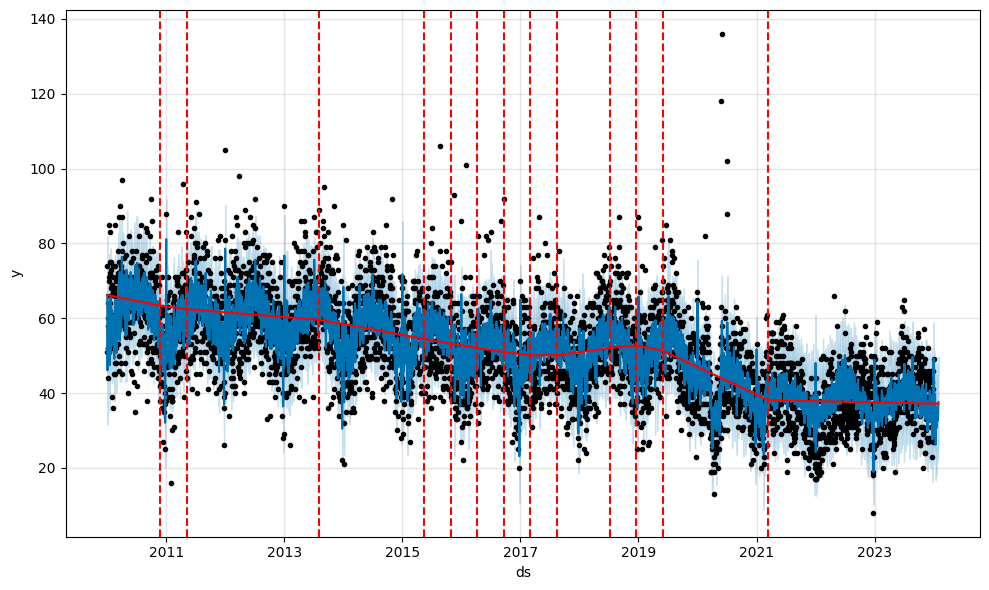

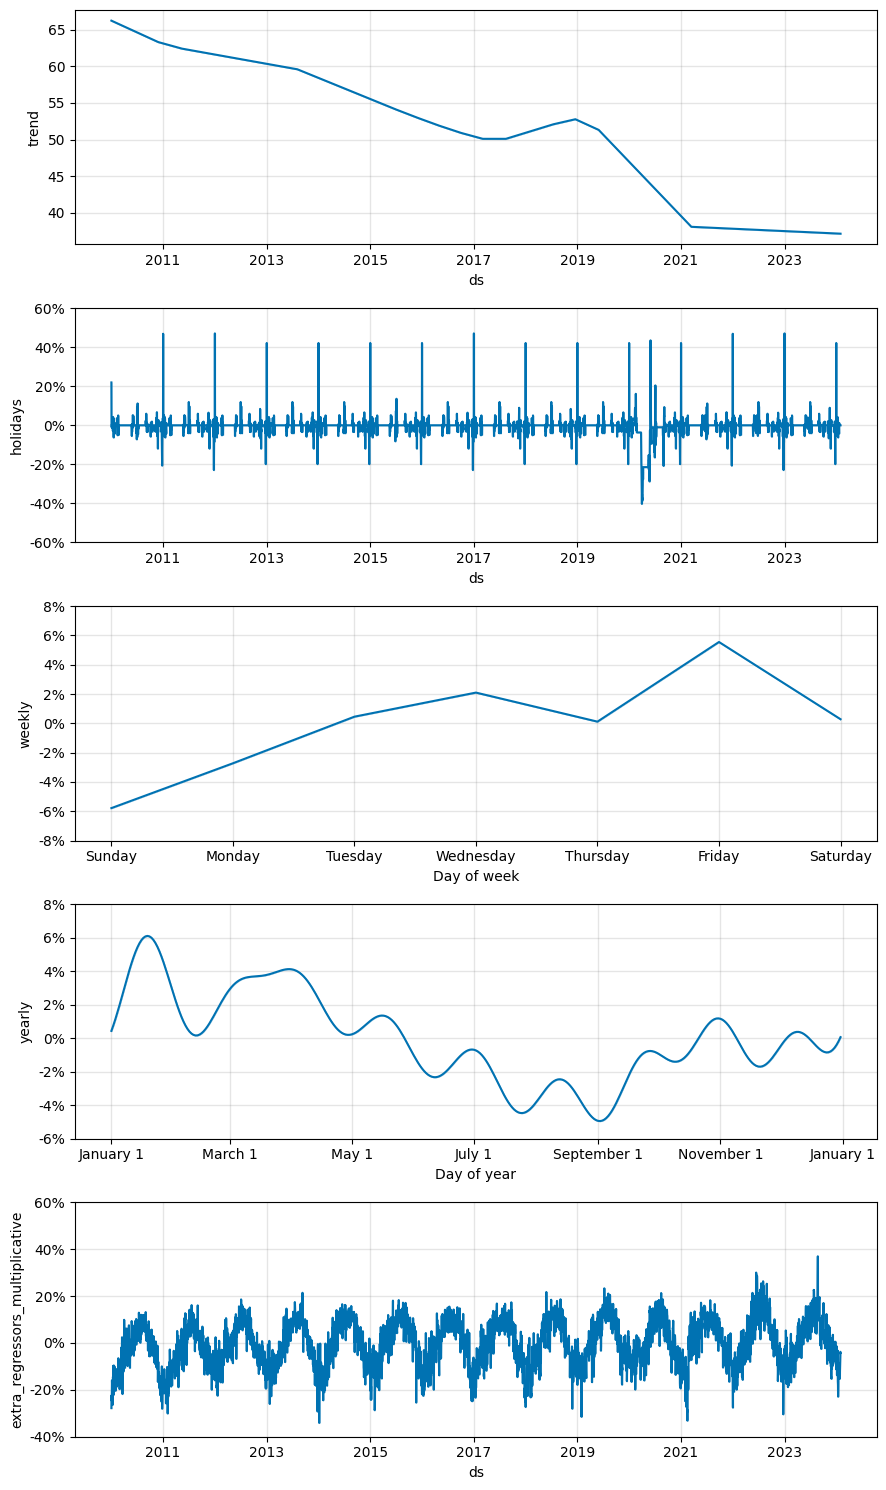

In [14]:
cutoff_date = '2024-01-01'
day_data = pd.read_csv('../day_data.csv')
day_data = day_data.rename(columns={'date': 'ds'})
day_data['ds'] = pd.to_datetime(day_data['ds'], format="%Y-%m-%d")
day_data = day_data[day_data['ds'] < '2024-02-01']

holidays = day_data[['ds', 'holiday']]
holidays['lower_window'] = -7
holidays['upper_window'] = 7
holidays['ds'] = pd.to_datetime(holidays['ds'], format="%Y-%m-%d")
calendar = holidays
calendar = calendar[~calendar['holiday'].isnull()]

start_date = day_data['ds'].min()
end_date = '2024-01-31'
all_dates = pd.DataFrame(
    data=pd.date_range(start_date, end_date, freq='d'),
    columns=['ds']
)
all_dates['ds'] = pd.to_datetime(all_dates['ds'], format="%Y-%m-%d")

day_data = day_data.drop(columns=['holiday'])
regressor_columns = ['moon', 'arrest', 'wd']
output_data = pd.merge(
    all_dates[all_dates['ds'] >= day_data['ds'].min()], 
    day_data, 
    how='left', 
    on=['ds'])
output_data.sort_values(
    by=['ds'], 
    ascending=True, 
    inplace=True, 
    ignore_index=True)

input_data = day_data.rename(columns={'num_crimes': 'y'})
enc = OneHotEncoder(drop='first')
wd_enc = enc.fit_transform(input_data[['wd']])
wd_enc = wd_enc.toarray()
wds = enc.get_feature_names_out(['wd'])
wd_enc = pd.DataFrame(wd_enc, columns=wds)
input_data = pd.concat([input_data, wd_enc], axis=1)
input_data = input_data.drop(columns=['wd'])
input_data = input_data[input_data['ds'] <= cutoff_date]

output_data = output_data.rename(columns={'num_crimes': 'y'})
wd_enc = enc.fit_transform(output_data[['wd']])
wds = enc.get_feature_names_out(['wd'])
wd_enc = wd_enc.toarray()
wd_enc = pd.DataFrame(wd_enc, columns=wds)
output_data = pd.concat([output_data, wd_enc], axis=1)
output_data = output_data.drop(columns=['wd'])

proph = Prophet(
    holidays=calendar,
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    holidays_prior_scale=0.05,
    changepoint_prior_scale=0.05,
    growth='linear',
    uncertainty_samples=50)

regressors = ['moon', 'arrest', 'wPC1', 'wPC2', 'wPC3']
for r in regressors:
    proph.add_regressor(r)
input_data = input_data[['ds', 'y', 'moon', 'arrest', 'wPC1', 'wPC2', 'wPC3']]
proph.fit(input_data)
forecast = proph.predict(output_data)

# pred accuracy
preds = forecast[forecast['ds'] >= cutoff_date]['yhat']
y_real = output_data[output_data['ds'] >= cutoff_date]['y']
print(f' mse: {mean_squared_error(y_real, preds)}')
print(f' rmse: {root_mean_squared_error(y_real, preds)}')

# plots
for_plot = proph.plot(forecast)
a = add_changepoints_to_plot(for_plot.gca(), proph, forecast)
comps = proph.plot_components(forecast)

In [16]:
forecast_df = forecast[['ds', 'yhat']]
forecast_df.to_csv('../forecast.csv', index=False)

In [93]:
# Neural Prophet

moon_df = input_data[input_data['moon'] == 1][['ds']]
moon_df['event'] = 'full_moon'
calendar_np = calendar[['ds', 'holiday']]
calendar_np = calendar_np.rename(columns={'holiday': 'event'})

np = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='multiplicative',
    n_lags=10,
    quantiles=[0.025, 0.975],
    learning_rate=0.0001,
    epochs=100
)
np.add_events("full_moon")
np.add_country_holidays("US", lower_window=-7, upper_window=7)
np.add_lagged_regressor('wPC1', n_lags=3)
np.add_lagged_regressor('wPC2', n_lags=3)
np.add_lagged_regressor('wPC3', n_lags=3)
np.add_lagged_regressor('arrest', n_lags=3)
input_all = np.create_df_with_events(input_data, moon_df)
input_all = input_all.drop(columns=['moon'])

np.fit(input_all)

output_data_np = output_data[['ds', 'y', 'arrest', 'wPC1', 'wPC2', 'wPC3']]
output_data_np
output_all = np.create_df_with_events(output_data_np, moon_df)

forecast = np.predict(output_all)

# pred accuracy
preds = forecast[forecast['ds'] > '2023-12-31']['yhat1']
y_real = output_data[output_data['ds'] > '2023-12-31']['y']
print(f' mse: {mean_squared_error(y_real, preds)}')
print(f' rmse: {root_mean_squared_error(y_real, preds)}')

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\neuralprophet\time_d

Epoch 70: 100%|██████████| 70/70 [00:02<00:00, 30.47it/s, loss=0.0206, v_num=3, MAE=6.720, RMSE=8.680, Loss=0.0214, RegLoss=0.000]   


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.981% of the data.
c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
c:\Users\benke\anaconda3\envs\durham\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.45it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



 mse: 37.057459549559304
 rmse: 6.087483843884869
